In [1]:
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
import glob

import deepposekit as dpk

import TrainingGeneratorTFRecord as TGTFR
import apt_dpk 
import run_apt_expts_2 as rae
import APT_interface as apt
import PoseTools as pt
import multiResData as mrd
import open_pose_data as opd
import util
import tfdatagen

import time
from os.path import expanduser

import mpl_toolkits.axes_grid1 as axg1

DPK_DSET = '/home/al/git/dpkd/datasets/fly/annotation_data_release.h5'

Using TensorFlow backend.
W0527 16:03:23.601255 139986914486080 deprecation_wrapper.py:119] From /home/al/git/APT_aldl/deepnet/open_pose4.py:12: The name tf.keras.initializers.random_normal is deprecated. Please use tf.compat.v1.keras.initializers.random_normal instead.



Your cache is: /dat0/apt/cache0426
Your models are: ['dpk']


## Create a DPK DG; create an APT TFR. Confirm that we read the identical ims/locs from both.

In [2]:
dg = dpk.DataGenerator(DPK_DSET)

LEAPSTRIPPEDLBL = '/dat0/jrcmirror/groups/branson/bransonlab/apt/experiments/data/leap_dataset_gt_stripped.lbl'
EXPNAME = 'dpkfly'
CACHE = '/dat0/apt/cache'
conf = apt.create_conf(LEAPSTRIPPEDLBL, 0, EXPNAME, \
                       CACHE, 'dpkfly', quiet=False)
conf.img_dim = 1  # hack, the leap stripped lbl has NumChans=3, but we created the tfr 
                  # directly using the dpk h5 which is 1-channel
conf.cachedir

# Cached images in strippedlbl differ from dpk h5! 
# - Ims are 3-chan grayscale vs 1-chan
# - Locs are off-by-one; strippedlbl prob correct (0-based)
#apt.create_tfrecord(conf,split=False,use_cache=True)


# So rather than use apt.create_tfrecord, we create the tfr directly from the h5 even 
# though it may be off-by-one for replication purposes

train_tf = conf.cachedir + '/train_TF.tfrecords'
#apt_dpk.apt_db_from_datagen(dg, train_tf)

/dat0/venv/env/lib/python3.6/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


In [ ]:
pt.count_records(train_tf), mrd.read_tfrecord_metadata(train_tf)

In [3]:
conf.batch_size

8

In [4]:
# Create a dset
ds = tfdatagen.create_tf_datasets(conf, is_raw=True, shuffle=False, infinite=False, dobatch=False)

W0527 16:03:28.669661 139986914486080 deprecation_wrapper.py:119] From /home/al/git/APT_aldl/deepnet/tfdatagen.py:662: The name tf.parse_single_example is deprecated. Please use tf.io.parse_single_example instead.

W0527 16:03:28.670805 139986914486080 deprecation_wrapper.py:119] From /home/al/git/APT_aldl/deepnet/tfdatagen.py:664: The name tf.FixedLenFeature is deprecated. Please use tf.io.FixedLenFeature instead.



In [5]:
# explicitly check/compare our TFR to the dg 
nkp = 32
INDICES_CHECK = [0,333,1499]
ims, locs, ifo, _ = mrd.read_and_decode_without_session(train_tf, nkp, indices=INDICES_CHECK)

W0527 16:03:31.928518 139986914486080 deprecation.py:323] From /home/al/git/APT_aldl/deepnet/multiResData.py:1088: tf_record_iterator (from tensorflow.python.lib.io.tf_record) is deprecated and will be removed in a future version.
Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


In [6]:
ims0 = dg.get_images(INDICES_CHECK)
locs0 = dg.get_keypoints(INDICES_CHECK)

In [7]:
# ... and TFD!!
def read_ds_idxed(dstrn, indices):
    it = dstrn.make_one_shot_iterator()
    nextel = it.get_next()
    c = 0
    res = []
    with tf.Session() as sess:
        while True:
            restmp = sess.run(nextel)
            if c in indices:
                res.append(restmp)
                print("Got {}".format(c))
            c += 1
            if all([c>x for x in indices]):
                break
    return res

In [8]:
resTFD = read_ds_idxed(ds, INDICES_CHECK)

W0527 16:03:38.054215 139986914486080 deprecation.py:323] From <ipython-input-7-eae407db2742>:3: DatasetV1.make_one_shot_iterator (from tensorflow.python.data.ops.dataset_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.


Got 0
Got 333
Got 1499


In [9]:
imsTFD, locsTFD, ifoTFD = zip(*resTFD)

In [11]:
ifoTFD[2]

array([1499., 1499., 1499.], dtype=float32)

In [12]:
for i in range(3):
    print(np.array_equal(ims[i],imsTFD[i]), np.array_equal(locs[i],locsTFD[i]), np.array_equal(ifo[i],ifoTFD[i]))

True True True
True True True
True True True


In [13]:
for i in range(3):
    print(np.array_equal(ims[i],ims0[i,...]), np.array_equal(locs[i],locs0[i,...]))

True True
True True
True True


In [198]:
def montage(ims0, locs=None, fignum=1, figsize = (10,10), axes_pad=0.0,
            share_all=True,label_mode='1',cmap='viridis',locsmrkr='.',
            locsmrkrsz=16):
    from matplotlib import cm
    
    ims = np.moveaxis(ims0, 0, -1)
    ims = ims[:,:,0,:]

    nim = ims.shape[2]
    nplotr = int(np.floor(np.sqrt(nim)))
    nplotc = int(np.ceil(nim/nplotr))
    
    fig = plt.figure(fignum, figsize=figsize)
    grid = axg1.ImageGrid(fig, 111,  # similar to subplot(111)
                          nrows_ncols=(nplotr, nplotc),
                          axes_pad=axes_pad,  # pad between axes in inch.
                          share_all=share_all,
                          label_mode=label_mode,
                          cbar_mode='each',
                         )
    
    
    for iim in range(nim):
        him = grid[iim].imshow(ims[...,iim], cmap=cmap)        
        cb = grid.cbar_axes[iim].colorbar(him)
        cb.ax.tick_params(color='r')
        plt.setp(plt.getp(cb.ax,'yticklabels'),color='w')
        if iim==0:
            cb0 = cb
        if locs is not None:
            jetmap = cm.get_cmap('jet')
            rgba = jetmap(np.linspace(0, 1, locs.shape[1]))
            grid[iim].scatter(locs[iim,:,0],locs[iim,:,1],c=rgba,
                              marker=locsmrkr, s=locsmrkrsz)

    
    for iim in range(nim, nplotr*nplotc):
        grid[iim].imshow(np.zeros(ims.shape[0:2]))

    plt.show()
    return fig, grid, cb0

In [15]:
ims0stk = np.moveaxis(ims0, 0, -1)
ims0stk = ims0stk[:,:,0,:]
ims0stk.shape

(192, 192, 3)

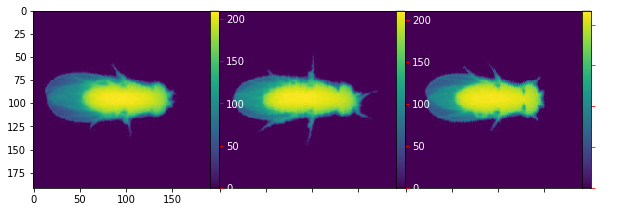

(<Figure size 720x720 with 6 Axes>,
 <mpl_toolkits.axes_grid1.colorbar.Colorbar at 0x7f507c0b8748>)

In [16]:
montage(ims0stk)

## Create a DPK TG; create an APT TGTFR; create a TFD; all using no augmentation. Confirm that we read the identical ims/locs from both.

In [17]:
DSFAC = 2
SIGMA = 5
VALSPLIT = 0.0
GRAPHSCALE = 1
tg = dpk.TrainingGenerator(generator=dg,
                           downsample_factor=DSFAC,
                           use_graph=True,
                           shuffle=False,
                           sigma=SIGMA,
                           validation_split=VALSPLIT,
                           graph_scale=GRAPHSCALE,
                           random_seed=0)


/home/al/git/dpk/deepposekit/io/TrainingGenerator.py:176: UserWarning: `n_validation` is 0. Increase `validation_split` to use a validation set.
  "`n_validation` is 0. Increase `validation_split` to use a validation set."


In [ ]:
tgc = tg.get_config()
tgc

In [ ]:
tg.train_range

In [18]:
g = tg(n_outputs=1, batch_size=4, 
       validation=False, confidence=True)
g

In [ ]:
util.dictdiff(vars(tg),vars(g))

In [ ]:
train_tf

In [ ]:
conf.dpk_input_sigma

In [ ]:
dg.graph, dg.swap_index, dg.compute_image_shape()

In [19]:
conf.img_dim = 1  # hack, the leap stripped lbl has NumChans=3, but we created the tfr 
                  # directly using the dpk h5 which is 1-channel
conf = apt_dpk.update_conf_dpk(conf,
                               dg.graph,
                               dg.swap_index,
                               n_keypoints=dg.n_keypoints,
                               imshape=dg.compute_image_shape(),
                               useimgaug=False,
                               imgaugtype=None)
vars(conf)         

{'rescale': 1.0,
 'label_blur_rad': 3.0,
 'batch_size': 8,
 'view': 0,
 'gamma': 0.1,
 'display_step': 50,
 'num_test': 24,
 'dl_steps': 60000,
 'decay_steps': 25000,
 'learning_rate': 0.0001,
 'trx_align_theta': False,
 'horz_flip': False,
 'vert_flip': False,
 'brange': [-0.1, 0.1],
 'crange': [0.9, 1.1],
 'rrange': 15.0,
 'trange': 10.0,
 'scale_range': 0.2,
 'scale_factor_range': 1.1,
 'use_scale_factor_range': False,
 'imax': 255.0,
 'check_bounds_distort': True,
 'adjust_contrast': False,
 'clahe_grid_size': 20,
 'normalize_img_mean': False,
 'normalize_batch_mean': False,
 'perturb_color': False,
 'flipLandmarkMatches': {},
 'learning_rate_multiplier': 1.0,
 'splitType': 'frame',
 'trainfilename': 'train_TF',
 'fulltrainfilename': 'fullTrain_TF',
 'valfilename': 'val_TF',
 'valdatafilename': 'valdata',
 'valratio': 0.3,
 'holdoutratio': 0.8,
 'max_n_animals': 1,
 'flipud': False,
 'unet_rescale': 1.0,
 'unet_keep_prob': 1.0,
 'unet_use_leaky': False,
 'use_pretrained_weights': T

In [20]:
tgtfr = TGTFR.TrainingGeneratorTFRecord(conf)

/dat0/venv/env/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [ ]:
c0 = tg.get_config()
c1 = tgtfr.get_config()
util.dictdiff(c0,c1)

In [ ]:
c0

In [21]:
def xylist2xyarr(xylist, xisscalarlist=False):
    x, y  = zip(*xylist)
    if xisscalarlist:
        assert all([len(z)==1 for z in x])
        x = [z[0] for z in x]
    x = np.concatenate(x,axis=0)
    y = np.concatenate(y,axis=0)
    return x, y
    

In [29]:
# For tg, originally we constructed without any aug,
# and with VALSPLIT=0. So we will use the training imgs
# to get unaugmented ims
g = tg(n_outputs=1, batch_size=4, 
       validation=False, confidence=True)

In [30]:
# For tgtfr
# 1. we did not have a val db, so it will use the trndb
# 2. validation=True =>  no distort/aug/shuffle.
conf.batch_size = 4 # hack again, note tgtfr uses batch_size in conf and ignores input arg
gtf = tgtfr(n_outputs=1, batch_size=4, 
       validation=True, confidence=True)

W0527 16:06:52.348155 139986914486080 TrainingGeneratorTFRecord.py:231] Ignoring batch specification of 4, conf batchsize is 4
W0527 16:06:52.351054 139986914486080 tfdatagen.py:637] tfdatagen makedatagen: /dat0/apt/cache/leap_dset/dpkfly/view_0/dpkfly/train_TF.tfrecords, distort/shuf=False/False, ppfun=ims_locs_preprocess_dpk, {'infinite': True}


In [ ]:
import importlib

In [ ]:
importlib.reload(tfdatagen)
importlib.reload(opd)

In [40]:
ds = tfdatagen.create_tf_datasets(conf, distort=False, shuffle=False, infinite=False)

In [32]:
imstgts_dpk = [g[x] for x in range(4)]
imsdpk, tgtsdpk = xylist2xyarr(imstgts_dpk)
imsdpk.shape, tgtsdpk.shape

((16, 192, 192, 1), (16, 48, 48, 66))

In [33]:
imstgts_apt = [next(gtf) for _ in range(4)]
imsapt, tgtsapt = xylist2xyarr(imstgts_apt, xisscalarlist=True)
imsapt.shape, tgtsapt.shape

/dat0/venv/env/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


((16, 192, 192, 1), (16, 48, 48, 66))

In [41]:
resDS = read_ds_idxed(ds, range(4))

/dat0/venv/env/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Got 0
Got 1
Got 2
Got 3


In [42]:
imsDS, tgtsDS = xylist2xyarr(resDS)
imsDS.shape, tgtsDS.shape

((16, 192, 192, 1), (16, 48, 48, 66))

In [43]:
print( np.allclose(imsdpk, imsapt), np.allclose(tgtsdpk, tgtsapt) )
print( np.array_equal(imsdpk, imsapt), np.array_equal(tgtsdpk, tgtsapt) )

True True
False True


In [44]:
print( np.allclose(imsdpk, imsDS), np.allclose(tgtsdpk, tgtsDS) )
print( np.array_equal(imsdpk, imsDS), np.array_equal(tgtsdpk, tgtsDS) )

True True
False False


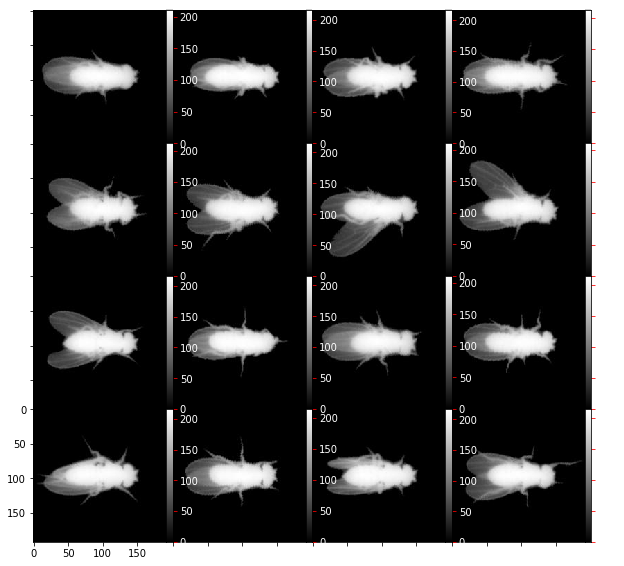

In [45]:
imsdpkstk = np.moveaxis(imsdpk,0,-1)
imsdpkstk = imsdpkstk[:,:,0,:]
hfig, grid, cb0 = montage(imsdpkstk,cmap='gray')

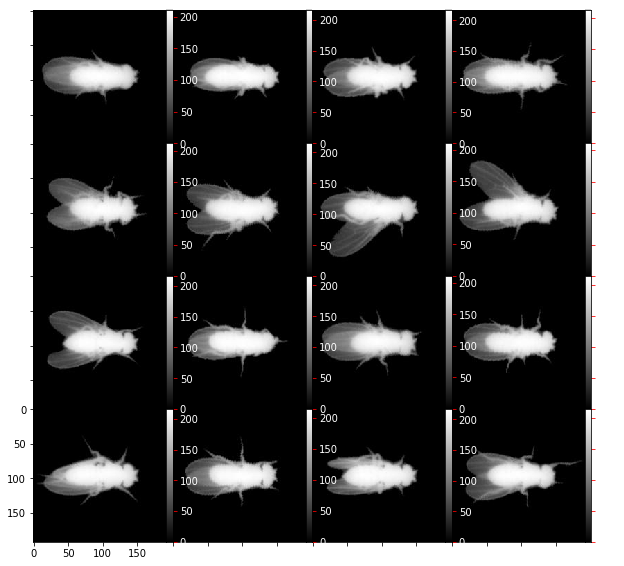

In [46]:
imsDSstk = np.moveaxis(imsDS,0,-1)
imsDSstk = imsDSstk[:,:,0,:]
hfig, grid, cb0 = montage(imsDSstk,cmap='gray')

## Create a TG with our default imgaug; v similar to DPK example notebook3; 
## Create a TGTFR with ". Reseed each IA, can we get reproducible augmented data?
## same with DS!!

In [47]:
ia = apt_dpk.make_imgaug_augmenter('dpkfly', dg)

In [48]:
DSFAC = 2
SIGMA = 5
VALSPLIT = 0.0
GRAPHSCALE = 1
tg = dpk.TrainingGenerator(generator=dg,
                           downsample_factor=DSFAC,
                           augmenter=ia,
                           use_graph=True,
                           shuffle=False,
                           sigma=SIGMA,
                           validation_split=VALSPLIT,
                           graph_scale=GRAPHSCALE,
                           random_seed=0)

# For tg, VALSPLIT=0 => use the training imgs
g = tg(n_outputs=1, batch_size=4, 
       validation=False, confidence=True)

RNGSEED = 17
g.augmenter.reseed(RNGSEED)
imstgts_dpk = [g[x] for x in range(3)]
imsdpk, tgtsdpk = xylist2xyarr(imstgts_dpk)
imsdpk.shape, tgtsdpk.shape

/home/al/git/dpk/deepposekit/io/TrainingGenerator.py:176: UserWarning: `n_validation` is 0. Increase `validation_split` to use a validation set.
  "`n_validation` is 0. Increase `validation_split` to use a validation set."


((12, 192, 192, 1), (12, 48, 48, 66))

In [49]:
# Create a TGTFR with our default imgaug
conf.img_dim = 1
conf = apt_dpk.update_conf_dpk(conf,
                               dg.graph,
                               dg.swap_index,
                               n_keypoints=dg.n_keypoints,
                               imshape=dg.compute_image_shape(),
                               useimgaug=True,
                               imgaugtype='dpkfly')
tgtfr = TGTFR.TrainingGeneratorTFRecord(conf)
tgtfr.conf.dpk_augmenter.reseed(RNGSEED)
conf.batch_size = 4 # hack again, note tgtfr uses batch_size in conf and ignores input arg
gtf = tgtfr(n_outputs=1, batch_size=4, 
       validation=False, confidence=True, shuffle=False)

imstgts_apt = [next(gtf) for _ in range(3)]

imsapt, tgtsapt = xylist2xyarr(imstgts_apt, xisscalarlist=True)
imsapt.shape, tgtsapt.shape

W0527 18:39:55.464176 139986914486080 TrainingGeneratorTFRecord.py:231] Ignoring batch specification of 4, conf batchsize is 4
W0527 18:39:55.466303 139986914486080 tfdatagen.py:637] tfdatagen makedatagen: /dat0/apt/cache/leap_dset/dpkfly/view_0/dpkfly/train_TF.tfrecords, distort/shuf=True/False, ppfun=ims_locs_preprocess_dpk, {'infinite': True}


((12, 192, 192, 1), (12, 48, 48, 66))

In [59]:
conf.cachedir


'/dat0/apt/cache/leap_dset/dpkfly/view_0/dpkfly'

In [50]:
ds = tfdatagen.create_tf_datasets(conf, shuffle=False, infinite=False)

In [51]:
resDS = read_ds_idxed(ds, range(3))

Got 0
Got 1
Got 2


In [52]:
imsDS, tgtsDS = xylist2xyarr(resDS)
imsDS.shape, tgtsDS.shape

((12, 192, 192, 1), (12, 48, 48, 66))

In [53]:
np.allclose(imsdpk,imsapt,), np.allclose(tgtsdpk, tgtsapt), \
np.array_equal(imsdpk, imsapt), np.array_equal(tgtsdpk, tgtsapt)

(True, True, True, True)

In [54]:
np.allclose(imsdpk,imsDS,), np.allclose(tgtsdpk, tgtsDS), \
np.array_equal(imsdpk, imsDS), np.array_equal(tgtsdpk, tgtsDS)

(True, True, True, False)

In [55]:
imsstk = np.moveaxis(imsdpk, 0, -1)
imsstk = imsstk[:,:,0,:]
imsstk.shape

(192, 192, 12)

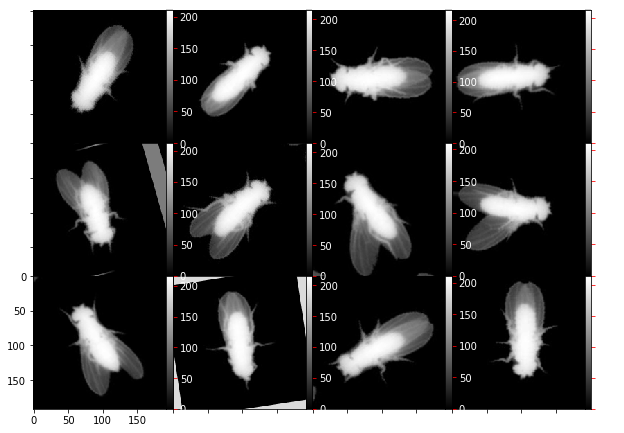

In [56]:
hfig, grid, cb0 = montage(imsstk,cmap='gray')

In [57]:
imsstk = np.moveaxis(imsDS, 0, -1)
imsstk = imsstk[:,:,0,:]
imsstk.shape

(192, 192, 12)

/dat0/venv/env/lib/python3.6/site-packages/matplotlib/axes/_base.py:3471: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=5.6621374e-14, top=5.6621374e-14
  'bottom=%s, top=%s') % (bottom, top))


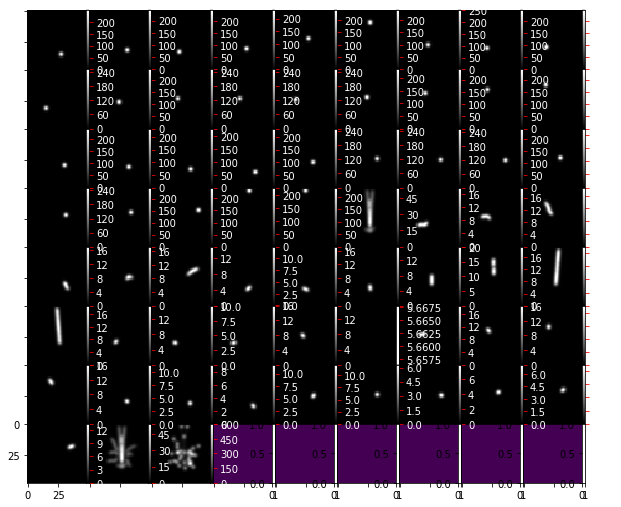

In [58]:
hfig, grid, cb0 = montage(tgtsDS[-1,...],cmap='gray')

## Create an Expdir with Val so we can test val

In [61]:
dg = dpk.DataGenerator(DPK_DSET)

LEAPSTRIPPEDLBL = '/dat0/jrcmirror/groups/branson/bransonlab/apt/experiments/data/leap_dataset_gt_stripped.lbl'
EXPNAME = 'val10pct'
CACHE = '/dat0/apt/cache'
conf = apt.create_conf(LEAPSTRIPPEDLBL, 0, EXPNAME, \
                       CACHE, 'dpkfly', quiet=False)
conf.img_dim = 1  # hack, the leap stripped lbl has NumChans=3, but we created the tfr 
                  # directly using the dpk h5 which is 1-channel
conf.cachedir

# Cached images in strippedlbl differ from dpk h5! 
# - Ims are 3-chan grayscale vs 1-chan
# - Locs are off-by-one; strippedlbl prob correct (0-based)
#apt.create_tfrecord(conf,split=False,use_cache=True)


# So rather than use apt.create_tfrecord, we create the tfr directly from the h5 even 
# though it may be off-by-one for replication purposes



/dat0/venv/env/lib/python3.6/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


'/dat0/apt/cache/leap_dset/dpkfly/view_0/val10pct'

In [63]:
n=len(dg)

In [64]:
VAL_PCT = 10
idx_val = np.random.choice(range(n), size=(int(n*VAL_PCT/100)), replace=False) 

In [66]:
len(idx_val)

150

In [67]:
train_tf = conf.cachedir + '/train_TF.tfrecords'
val_tf = conf.cachedir + '/val_TF.tfrecords'
apt_dpk.apt_db_from_datagen(dg, train_tf, val_idx=idx_val, val_tf=val_tf)

W0527 19:00:21.614506 139986914486080 deprecation_wrapper.py:119] From /home/al/git/APT_aldl/deepnet/apt_dpk.py:616: The name tf.python_io.TFRecordWriter is deprecated. Please use tf.io.TFRecordWriter instead.



Datagenerator image/keypt shapes are (192, 192, 1), (32, 2).
89,11 number of examples added to the training db and val db
180,20 number of examples added to the training db and val db
272,28 number of examples added to the training db and val db
362,38 number of examples added to the training db and val db
456,44 number of examples added to the training db and val db
546,54 number of examples added to the training db and val db
631,69 number of examples added to the training db and val db
728,72 number of examples added to the training db and val db
815,85 number of examples added to the training db and val db
907,93 number of examples added to the training db and val db
994,106 number of examples added to the training db and val db
1081,119 number of examples added to the training db and val db
1168,132 number of examples added to the training db and val db
1263,137 number of examples added to the training db and val db
1350,150 number of examples added to the training db and val db
1

### Note, the valtf is/was written to disk in sorted order by frame no

### Make a dpk.TG

In [165]:
idx_val.sort()

In [166]:
idx_val

array([   3,    5,   16,   27,   40,   56,   61,   64,   67,   71,   76,
        118,  127,  145,  146,  147,  158,  169,  177,  182,  206,  213,
        216,  217,  220,  228,  246,  261,  301,  303,  312,  323,  338,
        341,  369,  376,  378,  387,  401,  422,  459,  464,  465,  492,
        504,  507,  518,  523,  535,  537,  547,  550,  561,  579,  603,
        622,  638,  640,  643,  644,  650,  653,  656,  662,  672,  673,
        679,  680,  688,  700,  757,  791,  816,  817,  820,  831,  834,
        839,  840,  849,  859,  865,  869,  890,  898,  920,  951,  952,
        958,  968,  970,  985,  992, 1002, 1004, 1020, 1023, 1024, 1045,
       1051, 1054, 1055, 1061, 1063, 1080, 1086, 1101, 1102, 1106, 1113,
       1115, 1137, 1145, 1154, 1155, 1164, 1170, 1189, 1193, 1204, 1207,
       1211, 1215, 1218, 1224, 1229, 1234, 1242, 1252, 1256, 1259, 1282,
       1339, 1352, 1361, 1373, 1381, 1414, 1418, 1425, 1438, 1450, 1451,
       1453, 1456, 1471, 1472, 1479, 1480, 1493])

In [155]:
_, _, ifo, _ = mrd.read_and_decode_without_session(val_tf, nkp, indices=())

In [164]:
ifo = np.array(ifo)
all(np.diff(ifo[:,0])>0)

True

In [68]:
dg

In [167]:
DSFAC = 2
SIGMA = 5
VALSPLIT = 0.0
GRAPHSCALE = 1
ia = apt_dpk.make_imgaug_augmenter('dpkfly', dg)
tg = dpk.TrainingGenerator(generator=dg,
                           downsample_factor=DSFAC,
                           augmenter=ia,
                           use_graph=True,
                           shuffle=False,
                           sigma=SIGMA,
                           validation_split=VALSPLIT,
                           graph_scale=GRAPHSCALE,
                           random_seed=0)

/home/al/git/dpk/deepposekit/io/TrainingGenerator.py:176: UserWarning: `n_validation` is 0. Increase `validation_split` to use a validation set.
  "`n_validation` is 0. Increase `validation_split` to use a validation set."


In [168]:
# Massage to use my val split
tg.val_index = idx_val
train_index = np.invert(np.isin(tg.index, tg.val_index))
tg.train_index = tg.index[train_index]
tg.n_validation = len(idx_val)

In [72]:
cfg = tg.get_config()

In [213]:
# For tg, VALSPLIT=0 => use the training imgs
g = tg(n_outputs=1, batch_size=4, 
       validation=True, confidence=False)

In [170]:
g.val_index[:10]

array([ 3,  5, 16, 27, 40, 56, 61, 64, 67, 71])

In [215]:
RNGSEED = 17
g.augmenter.reseed(RNGSEED)
imstgts_dpk = [g[x] for x in range(150//4)]
imsdpk, tgtsdpk = xylist2xyarr(imstgts_dpk)
imsdpk.shape, tgtsdpk.shape

((148, 192, 192, 1), (148, 32, 2))

In [226]:
tgtsdpk[-148,...]

array([[148.        ,  97.37982178],
       [137.62017822,  80.86053467],
       [135.91098022, 112.43026733],
       [128.94955444,  96.37982178],
       [ 99.72848511,  95.83531189],
       [ 48.83234406,  96.02522278],
       [119.24035645, 108.20178223],
       [127.81008911, 118.62017822],
       [146.06677246, 104.5712204 ],
       [162.24629211, 108.04450989],
       [108.93768311, 108.16320801],
       [100.65875244, 120.20178223],
       [102.62017822, 127.62017822],
       [100.62017822, 144.10089111],
       [ 92.50741577, 107.39169312],
       [ 82.67359161, 116.62017822],
       [ 73.68546295, 109.53115845],
       [ 61.14243317, 108.65578461],
       [122.86053467,  83.84866333],
       [124.85756683,  73.96142578],
       [142.83383179,  75.89910889],
       [157.01187134,  68.418396  ],
       [107.51928711,  80.08901978],
       [102.290802  ,  70.17803955],
       [109.77151489,  66.27893066],
       [113.82196045,  50.17804337],
       [ 87.37982178,  81.60830688],
 

In [173]:
conf.img_dim = 1
conf = apt_dpk.update_conf_dpk(conf,
                               dg.graph,
                               dg.swap_index,
                               n_keypoints=dg.n_keypoints,
                               imshape=dg.compute_image_shape(),
                               useimgaug=True,
                               imgaugtype='dpkfly')
conf.batch_size=4

In [174]:
import importlib
importlib.reload(tfdatagen)

<module 'tfdatagen' from '/home/al/git/APT_aldl/deepnet/tfdatagen.py'>

In [228]:
ds = tfdatagen.create_tf_datasets(conf, is_val=True, distort=False, shuffle=False, infinite=False, drawconf=False)

In [139]:
dsraw = tfdatagen.create_tf_datasets(conf, is_val=True, is_raw=True, distort=False, shuffle=False, infinite=False, drawconf=False)

In [227]:
resDSraw = read_ds_idxed(dsraw,range(150//4))

Got 0
Got 1
Got 2
Got 3
Got 4
Got 5
Got 6
Got 7
Got 8
Got 9
Got 10
Got 11
Got 12
Got 13
Got 14
Got 15
Got 16
Got 17
Got 18
Got 19
Got 20
Got 21
Got 22
Got 23
Got 24
Got 25
Got 26
Got 27
Got 28
Got 29
Got 30
Got 31
Got 32
Got 33
Got 34
Got 35
Got 36


In [151]:
resDSraw[0][2]

array([[ 3.,  3.,  3.],
       [ 5.,  5.,  5.],
       [16., 16., 16.],
       [27., 27., 27.]], dtype=float32)

In [142]:
imsDSraw, locsDSraw, tgtsDSraw = xylist2xyarr(resDSraw)
imsDSraw.shape, locsDSraw,shape, tgtsDSraw.shape

ValueError: too many values to unpack (expected 2)

In [229]:
resDS = read_ds_idxed(ds, range(150//4))

Got 0
Got 1
Got 2
Got 3
Got 4
Got 5
Got 6
Got 7
Got 8
Got 9
Got 10
Got 11
Got 12
Got 13
Got 14
Got 15
Got 16
Got 17
Got 18
Got 19
Got 20
Got 21
Got 22
Got 23
Got 24
Got 25
Got 26
Got 27
Got 28
Got 29
Got 30
Got 31
Got 32
Got 33
Got 34
Got 35
Got 36


In [230]:
imsDS, tgtsDS = xylist2xyarr(resDS)
imsDS.shape, tgtsDS.shape

((148, 192, 192, 1), (148, 32, 2))

In [236]:
tgtsDS[-140,...]

array([[145.62018 ,  98.48071 ],
       [136.81009 ,  81.18991 ],
       [133.62018 , 113.81009 ],
       [129.      ,  97.62018 ],
       [ 99.949554,  96.37982 ],
       [ 55.      ,  93.      ],
       [113.      , 109.      ],
       [125.37982 , 115.      ],
       [127.24036 , 120.75964 ],
       [129.      , 130.      ],
       [106.      , 109.      ],
       [ 96.32938 , 121.81009 ],
       [ 91.24036 , 124.56973 ],
       [ 83.      , 136.      ],
       [ 90.      , 108.      ],
       [ 76.48071 , 121.43027 ],
       [ 65.      , 107.      ],
       [ 36.821957, 107.91098 ],
       [120.      ,  83.      ],
       [129.      ,  75.      ],
       [130.      ,  70.      ],
       [134.      ,  61.      ],
       [110.      ,  83.      ],
       [105.      ,  70.      ],
       [101.      ,  67.      ],
       [ 96.      ,  54.709198],
       [ 95.75964 ,  90.81009 ],
       [ 81.56973 ,  68.949554],
       [ 72.14837 ,  72.36498 ],
       [ 60.961426,  83.9911  ],
       [ 3

In [178]:
np.allclose(imsdpk,imsDS,), np.allclose(tgtsdpk, tgtsDS), \
np.array_equal(imsdpk, imsDS), np.array_equal(tgtsdpk, tgtsDS)

(True, True, True, True)

In [212]:
tgtsDS[2,:]

array([[147.24036 ,  95.      ],
       [137.43027 ,  80.56973 ],
       [139.      , 111.43027 ],
       [129.      ,  96.      ],
       [100.      ,  97.      ],
       [ 46.569733,  95.949554],
       [122.949554, 107.34125 ],
       [130.55786 , 114.07715 ],
       [136.88724 , 113.08902 ],
       [142.08902 , 117.038574],
       [117.75964 , 107.10089 ],
       [106.9733  , 117.27893 ],
       [ 99.32938 , 112.581604],
       [ 91.2908  , 112.27893 ],
       [ 93.43027 , 105.62018 ],
       [ 85.48516 , 122.23294 ],
       [ 63.632046, 109.34125 ],
       [ 33.08012 , 109.97033 ],
       [118.62018 ,  85.18991 ],
       [129.46884 ,  77.24036 ],
       [136.32938 ,  78.46884 ],
       [144.      ,  72.      ],
       [104.51929 ,  86.62018 ],
       [ 92.32938 ,  69.62018 ],
       [ 85.139465,  69.62018 ],
       [ 72.27893 ,  55.430267],
       [ 96.611275,  87.79822 ],
       [ 89.19288 ,  75.7092  ],
       [ 65.      ,  79.62018 ],
       [ 48.038574,  74.038574],
       [ 2

In [179]:
imsstk = np.moveaxis(imsDS, 0, -1)
imsstk = imsstk[:,:,0,:]
imsstk.shape

(192, 192, 20)

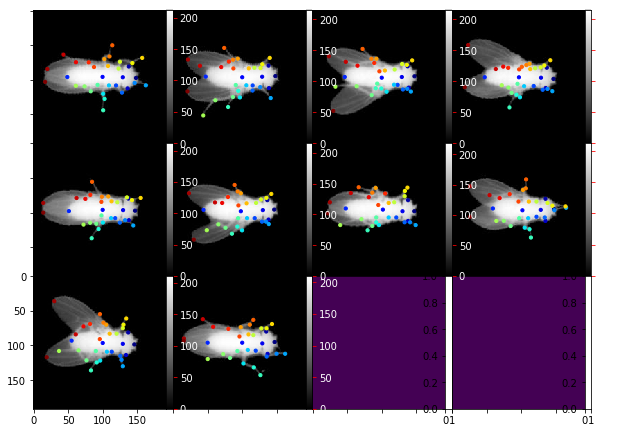

(<Figure size 720x720 with 24 Axes>,
 <mpl_toolkits.axes_grid1.colorbar.Colorbar at 0x7f4f3b1c8a20>)

In [202]:
montage(imsDS[:10,...],locs=tgtsDS[:10,...],cmap='gray',locsmrkrsz=40)

'1.14.0'

In [ ]:
## TODO: use pt for tgtfr. how does it compare?